In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')
import helper as hp

# MLP

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, Callback
from keras.utils import np_utils
import keras.backend as K
from keras import Model
import datetime

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from itertools import cycle
from keras.models import clone_model



In [5]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']




4422102/4422102 [==============================] - 0s 0us/step


### Sparse arrays

In [6]:
y_sparse_train = np.zeros([len(y_train),10])
y_sparse_test = np.zeros([len(y_test),10])
for idx in range(len(y_train)):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(len(y_test)):
    y_sparse_test[idx,y_test[idx]] = 1

## 3 Hidden layers


In [9]:
K.clear_session()

model_1 = Sequential()
model_1.add(Flatten(input_shape=(28,28)))
model_1.add(BatchNormalization())
model_1.add(Dense(512, activation = 'relu', kernel_initializer = 'random_normal'))
model_1.add(Dropout(0.125))
model_1.add(Dense(128, activation = 'relu', kernel_initializer = 'random_normal'))
model_1.add(Dropout(0.125))
model_1.add(Dense(64, activation = 'relu', kernel_initializer = 'random_normal'))
model_1.add(Dropout(0.125))
model_1.add(Dense(10, activation='softmax', kernel_initializer='random_normal', name='Output'))

model_1.summary()

model_1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [10]:
model_2 = clone_model(model_1)
model_2.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_trained_2 = model_2.fit(x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=1,
                                  validation_data = (x_test, y_sparse_test),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )

Epoch 1/512
469/469 [==============================] - 5s 4ms/step - loss: 0.5222 - accuracy: 0.8142 - val_loss: 0.4060 - val_accuracy: 0.8526
Epoch 2/512
469/469 [==============================] - 2s 5ms/step - loss: 0.3664 - accuracy: 0.8681 - val_loss: 0.3730 - val_accuracy: 0.8642
Epoch 3/512
469/469 [==============================] - 2s 4ms/step - loss: 0.3310 - accuracy: 0.8802 - val_loss: 0.3487 - val_accuracy: 0.8731
Epoch 4/512
469/469 [==============================] - 2s 4ms/step - loss: 0.3043 - accuracy: 0.8874 - val_loss: 0.3306 - val_accuracy: 0.8795
Epoch 5/512
469/469 [==============================] - 2s 4ms/step - loss: 0.2840 - accuracy: 0.8945 - val_loss: 0.3395 - val_accuracy: 0.8812
Epoch 6/512
469/469 [==============================] - 2s 5ms/step - loss: 0.2678 - accuracy: 0.9009 - val_loss: 0.3251 - val_accuracy: 0.8823
Epoch 7/512
469/469 [==============================] - 2s 4ms/step - loss: 0.2540 - accuracy: 0.9038 - val_loss: 0.3322 - val_accuracy: 0.8844

In [11]:
weights_1 = model_1.get_weights()
weights_2 = model_2.get_weights()

weights_diff = []

for i in range(len(weights_1)):
    weights_diff.append(weights_1[i] - weights_2[i])

weights_3 = []

for i in range(len(weights_diff)):
    weights_3.append(np.where(weights_diff[i] > np.percentile(weights_diff[i], 50), weights_2[i], 0))

model_3 = clone_model(model_1)

model_3.set_weights(weights_3)

model_3.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [12]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [13]:
score_3 = model_3.evaluate(x_test, y_sparse_test, verbose=0)
print('Accuracy for model 3 before training:', score_3[1])

Accuracy for model 3 before training: 0.11749999970197678


In [14]:
model_trained_3 = model_3.fit(x_train,
                              y_sparse_train,
                              epochs=512, batch_size=128,
                              verbose=1,
                              validation_data = (x_test, y_sparse_test),
                              callbacks=[hp.callback_EarlyStopping()],
                              )

Epoch 1/512
469/469 [==============================] - 2s 4ms/step - loss: 0.9769 - accuracy: 0.6241 - val_loss: 0.4991 - val_accuracy: 0.8178
Epoch 2/512
469/469 [==============================] - 2s 4ms/step - loss: 0.4688 - accuracy: 0.8327 - val_loss: 0.4069 - val_accuracy: 0.8530
Epoch 3/512
469/469 [==============================] - 2s 5ms/step - loss: 0.3888 - accuracy: 0.8605 - val_loss: 0.3766 - val_accuracy: 0.8603
Epoch 4/512
469/469 [==============================] - 2s 4ms/step - loss: 0.3436 - accuracy: 0.8767 - val_loss: 0.3535 - val_accuracy: 0.8701
Epoch 5/512
469/469 [==============================] - 2s 4ms/step - loss: 0.3217 - accuracy: 0.8824 - val_loss: 0.3453 - val_accuracy: 0.8762
Epoch 6/512
469/469 [==============================] - 2s 4ms/step - loss: 0.3006 - accuracy: 0.8902 - val_loss: 0.3564 - val_accuracy: 0.8719
Epoch 7/512
469/469 [==============================] - 2s 4ms/step - loss: 0.2837 - accuracy: 0.8961 - val_loss: 0.3316 - val_accuracy: 0.8810

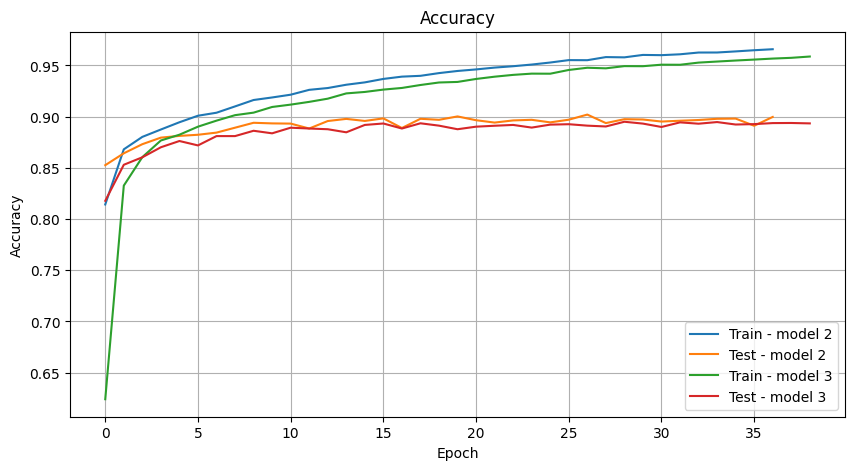

In [15]:
# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(model_trained_2.history['accuracy'])
plt.plot(model_trained_2.history['val_accuracy'])
plt.plot(model_trained_3.history['accuracy'])
plt.plot(model_trained_3.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train - model 2', 'Test - model 2', 'Train - model 3', 'Test - model 3'])
plt.grid()
plt.show()